In [2]:
import pandas as pd
import json
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
from multiprocessing import Pool
from tqdm.notebook import tqdm
from sklearn.linear_model import LinearRegression

In [3]:
lines = list(open('./model_annotations.aligned.scored.jsonl', 'rt'))

In [4]:
obj = json.loads(lines[10])
obj

{'id': 'dm-test-8764fb95bfad8ee849274873a92fb8d6b400eee2',
 'decoded': "paul merson has restarted his row with andros townsend after the tottenham midfielder was brought on with only seven minutes remaining in his team 's 0-0 draw with burnley on sunday . ' paul merson had another dig at andros townsend after his appearance for tottenham against burnley . townsend was brought on in the 83rd minute for tottenham as they drew 0-0 against burnley .",
 'expert_annotations': [{'coherence': 3,
   'consistency': 5,
   'fluency': 5,
   'relevance': 3},
  {'coherence': 2, 'consistency': 5, 'fluency': 4, 'relevance': 2},
  {'coherence': 3, 'consistency': 5, 'fluency': 5, 'relevance': 4}],
 'turker_annotations': [{'coherence': 2,
   'consistency': 2,
   'fluency': 2,
   'relevance': 2},
  {'coherence': 2, 'consistency': 2, 'fluency': 2, 'relevance': 2},
  {'coherence': 2, 'consistency': 2, 'fluency': 2, 'relevance': 2},
  {'coherence': 2, 'consistency': 2, 'fluency': 2, 'relevance': 2},
  {'coher

In [5]:
def annotations(x, annotations, agg=lambda x: np.mean(list(x.values()))):
    scores = []
    if annotations not in x:
        return []
    
    for expert in x[annotations]:
        scores.append(agg(expert)) 
    return scores

In [6]:
data = []

for line in lines:
    obj = json.loads(line)
    
    row = []
    row.append(obj['id'])
    row.append(obj['decoded'])
    row.append(obj['references'][0])
    row.append(obj['model_id'])
    
    row.append(obj['metric_scores_11']['rouge']['rouge_4_f_score'])
    row.append(obj['metric_scores_11']['meteor'])
    row.append(obj['metric_scores_11']['mover_score'])
    row.append(obj['metric_scores_11']['bert_score_f1'])
    row.append(obj['metric_scores_1']['supert'][0])
    
    for expert_annotation in annotations(obj, 'expert_annotations'):
        r = row.copy()
        r.append('expert')
        r.append(expert_annotation)
        data.append(r)
        
    for expert_annotation in annotations(obj, 'turker_annotations'):
        r = row.copy()
        r.append('turker')
        r.append(expert_annotation)
        data.append(r)
    
df = pd.DataFrame(data)
df.columns = ['id', 'output', 'reference_1', 'system', 'r11_rouge_4_f_score', 'r11_meteor', 'r11_mover_score', 'r11_bert_score', 'r1_supert', 'type', 'score']
df.head(1)

,id,output,reference_1,system,r11_rouge_4_f_score,r11_meteor,r11_mover_score,r11_bert_score,r1_supert,type,score
0,dm-test-8764fb95bfad8ee849274873a92fb8d6b400eee2,paul merson was brought on with only seven min...,Andros Townsend an 83rd minute sub in Tottenha...,M11,0.00185,0.220548,0.207145,0.399867,0.508232,expert,2.25


<AxesSubplot:xlabel='score', ylabel='r1_supert'>

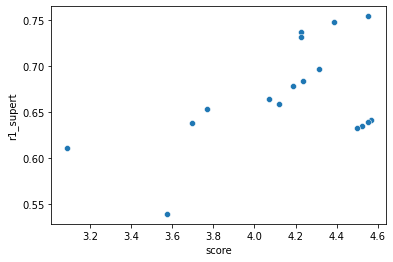

In [133]:
turker_df = df[df.type == 'turker']
turker_means = turker_df.groupby('system')['score'].mean()

expert_df = df[df.type == 'expert']
expert_means = expert_df.groupby('system')['score'].mean()

metric_df = df[~df.duplicated(['id','system'])]
metric_means = metric_df.groupby('system')['r1_supert'].mean()

sns.scatterplot(x=expert_means, y=metric_means)

In [74]:
def get_preds(pred_means, true_means):
    true_means = true_means.to_numpy().reshape(-1, 1)
    pred_means = pred_means.to_numpy().reshape(-1, 1)
    
    
    lr = LinearRegression().fit(pred_means, true_means)
    adjusted_pred_means = lr.predict(pred_means)
    
    return adjusted_pred_means.reshape(-1)

In [119]:
# adopted from https://github.com/rasbt/mlxtend/blob/master/mlxtend/evaluate/bias_variance_decomp.py
def bias_var_decomposition(metric_results, true_preds):
    main_predictions = metric_results.mean(axis=0)
    
    mse = lambda x, y: np.mean(np.square(x - y))
    
    avg_expected_loss = mse(metric_results, true_preds)
    avg_bias = mse(main_predictions, true_preds)
    avg_var_contrib = mse(metric_results, main_predictions)

    return avg_expected_loss, avg_bias, avg_var_contrib

def bias_var_noise_decomposition(metric_results, human_results, true_preds):
    main_predictions = metric_results.mean(axis=0)
    optimal_predictions = human_results.mean(axis=0)
    
    mse = lambda x, y: np.mean(np.square(x - y))
    
    avg_expected_loss = mse(metric_results, human_results)
    avg_noise_contrib = mse(human_results, true_preds)
    avg_bias = mse(main_predictions, true_preds)
    avg_var_contrib = mse(metric_results, main_predictions)

    return avg_expected_loss, avg_bias, avg_var_contrib, avg_noise_contrib

In [122]:
a, b, c, d = bias_var_noise_decomposition(metric_results, human_results, expert_means.to_numpy())
print(a, b, c, d)
a, b + c + d

0.08877220780204251 0.08219280950333607 0.007075574912676702 0.0009489823876637026


(0.08877220780204251, 0.09021736680367648)

In [143]:
def f(metric):
    groups = expert_df.groupby(['system']).apply(lambda x: x.sample(frac=1, replace=True))
    observed_means = groups['score'].groupby(level=[0]).mean()
    
    if metric == 'human':
        groups = expert_df.groupby(['system']).apply(lambda x: x.sample(frac=1, replace=True))
        agg_means = groups.groupby(level=[0]).apply(lambda x: x['score'].mean())
    else:
        agg_means = groups.groupby(level=[0]).apply(lambda x: x[metric].mean())
        
    return get_preds(observed_means, expert_means), get_preds(agg_means, observed_means)

WORKERS = 12
NUM_TRIALS = 5000
CHUNKSIZE = int(NUM_TRIALS / WORKERS / 10)
metrics = ['human', 'r11_rouge_4_f_score', 'r11_meteor', 'r11_mover_score', 'r11_bert_score', 'r1_supert']
results = {}

with Pool(WORKERS) as p:
    for metric in tqdm(metrics):
        it = tqdm(p.imap_unordered(f, [metric]*NUM_TRIALS, chunksize=CHUNKSIZE), total=NUM_TRIALS)
        output = list(it)

        human_results = np.array([ i[0] for i in output ])
        metric_results = np.array([ i[1] for i in output ])
        
        results[metric] = bias_var_noise_decomposition(metric_results, human_results, expert_means.to_numpy())

In [144]:
for metric, (avg_expected_loss, avg_bias, avg_var_contrib, avg_noise_contrib) in sorted(list(results.items()), key=lambda x: x[1][0]):
    if metric == 'human':
        print('%s & %.3f & %.3f & %.3f & {\\bf %.3f } \\\\' % (metric, avg_expected_loss, avg_noise_contrib, avg_bias, avg_var_contrib))
    else:
        print('%s & %.3f & %.3f & {\\bf %.3f } & %.3f \\\\' % (metric.replace('_','-'), avg_expected_loss, avg_noise_contrib, avg_bias, avg_var_contrib))

human & 0.002 & 0.001 & 0.000 & {\bf 0.001 } \\
r11-rouge-4-f-score & 0.087 & 0.001 & {\bf 0.081 } & 0.007 \\
r11-meteor & 0.110 & 0.001 & {\bf 0.110 } & 0.001 \\
r11-mover-score & 0.111 & 0.001 & {\bf 0.111 } & 0.001 \\
r11-bert-score & 0.112 & 0.001 & {\bf 0.111 } & 0.001 \\
r1-supert & 0.119 & 0.001 & {\bf 0.120 } & 0.000 \\


In [145]:
for metric, (avg_expected_loss, avg_bias, avg_var_contrib, avg_noise_contrib) in sorted(list(results.items()), key=lambda x: x[1][0]):
    print(metric)
    print(avg_expected_loss)
    print(avg_noise_contrib + avg_bias + avg_var_contrib)

human
0.0021341856333518166
0.0021009827888672757
r11_rouge_4_f_score
0.08737738176043662
0.08917451666539691
r11_meteor
0.1102411440776584
0.11202546466554097
r11_mover_score
0.11105681863205304
0.11305527356034782
r11_bert_score
0.11173839709677702
0.11356831196584173
r1_supert
0.1192161323911981
0.12094081283998173
